# 7장. 앙상블 학습과 랜덤 포레스트

무작위로 선정된 수천 명의 사람에게 복잡한 질문을 하고 대답을 모은다고 가정해보자. 많은 경우 이렇게 모은 답이 전문가의 답보다 낫다.

이를 대중의 지혜라고 한다. 이와 비슷하게 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있을 것이다.

이런 일련의 예측기를 **앙상블 Ensemble**이라고 부르고, 이를 **앙상블 학습 Ensemble Learning**이라고 하며, 앙상블 학습 알고리즘을 **앙상블 방법 Ensemble Method**라고 한다.

앞에서 본 결정 트리의 경우, 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있고, 모든 개별 트리의 예측을 모아 가장 많은 선택을 받은 클래스를 예측으로 삼을 수 있다.

결정 트리의 앙상블을 **랜덤 포레스트 Random Forest**라고 하며, 가장 간단한 방법임에도 오늘날 가장 강력한 머신러닝 알고리즘 중 하나이다.

게다가 프로젝트의 마지막에 다다르면 흔히 앙상블 방법을 사용하여 이미 만든 여러 괜찮은 예측기를 연결하여 더 좋은 예측기를 만들곤 한다. 실제로 많은 머신러닝 경연 대회에서 우승하는 솔루션은 여러 앙상블 방법인 경우가 많고, 특히 넷플릭스 대회에서 그러한 경향을 띤다.

이 장에서는 랜덤 포레스트를 비롯한 **배깅, 부스팅, 스태킹** 등 가장 인기 있는 앙상블 방법을 설명한다.


# 1. 투표 기반 분류기

정확도가 80%인 분류기 여러 개를 훈련시켰다고 가정하자. 더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다.

이렇게 다수결 투표로 정해지는 분류기를 **직접 투표 Hard Voting** 분류기라고 한다. 대부분의 경우, 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높은 경우가 많다.

사실 각 분류기가 **약한 학습기 Weak Learner** (즉, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기) 일지라고 충분하게 많고 다양하다면 앙상블은 **강한 학습기 Strong Learner**가 될 수 있다.

이게 어떻게 가능할까? 이는 **큰 수의 법칙 Law of Large Number** 때문이다. 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다고 가정할 경우, 75%의 정확도를 기대할 수 있다.

하지만 이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능하다.

사이킷런의 투표 기반 분류기를 만들고 훈련시켜보자.

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples = 500, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y)

C:\Users\ud803\Anaconda3\envs\hands_on_ml\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=10)
svm_clf = SVC(gamma='auto')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=Non...
                                        

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.896


예상대로 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높다.

모든 분류기가 클래스의 확률을 예측할 수 있으면, (즉, `predict_proba()` 함수가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다.

이를 **간접 투표 Soft Voting** 방식이라고 한다. 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높다.

이 방식을 사용하려면 `voting="soft"`로 바꾸고, 모든 분류기가 클래스의 확률을 추정할 수 있으면 된다.

`SVC`는 기본값에서 확률을 제공하지 않으므로 `probability` 매개변수를 `True`로 지정해야 한다.

In [7]:
log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=10)
svm_clf = SVC(gamma='auto', probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=Non...
                                        

In [8]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.888


간접 투표 방식을 사용하면 일반적으로 정확도가 더 높다. (내 경우는 더 낮게 나왔다.)

# 2. 배깅과 페이스팅

다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것이고, 또 다른 방법은 같은 알고리즘을 다른 훈련 세트의 서브셋에 학습시키는 것이다. 

훈련 세트에서 중복을 허용하여 샘플링하는 방식을 **배깅 Bagging**(Bootstrap Aggregating) 이라 하며, 중복을 허용하지 않고 샘플링하는 방식을 **페이스팅 Pasting**이라고 한다.

다시 말해 배깅과 페이스팅에서는 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다. 하지만 배깅만이 한 예측기를 위해 같은 훈렴 샘플을 여러 번 샘플링할 수 있다.

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다. 수집 함수는 전형적으로 분류일 때 **통계적 최빈값 Statistical Mode**이고 회귀에 대해서는 평균을 계산한다.

개별 예측기는 원본 훈련 세트보다 훨씬 크게 편항되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소한다. 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.

예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있다. 유사하게 예측도 병렬로 수행할 수 있으며, 이런 확장성 덕분에 배깅과 페이스팅의 인기는 높다.

## 2.1 사이킷런의 배깅과 페이스팅

사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 `BaggingClassifier` 를 제공한다. 다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드이다.

각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련된다. 

(bagging일 경우임. 페이스팅을 사용하려면 `bootstrap=False` 지정, `n_jobs`는 CPU 코어 수를 지정하며, -1로 지정하면 가용한 모든 코어를 사용한다.)

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.88


In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(model, X, y):
    x0, x1 = np.meshgrid(
        np.linspace(-1.5, 2.5, 500),
        np.linspace(-1, 1.5, 500)
    )
    plt.axis([-1.5, 2.5, -1, 1.5])
    plt.plot(X[y==0, 0], X[y==0, 1], 'rs')
    plt.plot(X[y==1, 0], X[y==1, 1], 'b^')
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    y_pred = model.predict(np.c_[x0.ravel(), x1.ravel()])
    decision_boundary = model.predict_proba(np.c_[x0.ravel(), x1.ravel()])
    contour_1 = plt.contour(x0, x1, y_pred.reshape(x0.shape))
    contour_2 = plt.contourf(x0, x1, y_pred.reshape(x0.shape), cmap = custom_cmap)
    plt.clabel(contour_1)

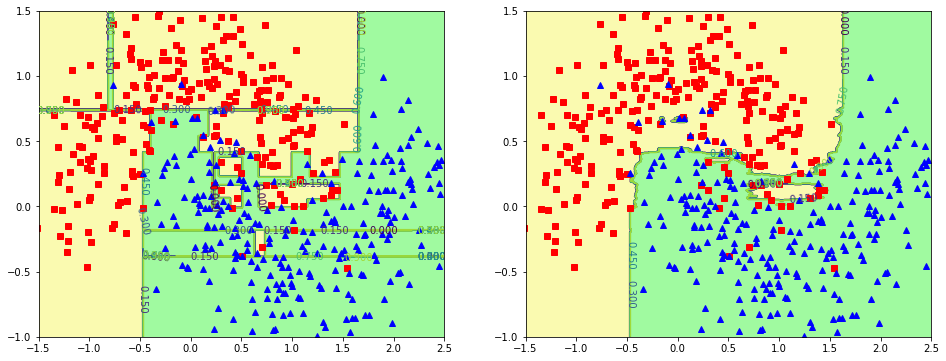

In [12]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_decision_boundary(tree_clf, X, y)
plt.subplot(1, 2, 2)
plot_decision_boundary(bag_clf, X, y)
plt.show()

위 결과를 보면, 왼쪽의 단일 트리보다 오른쪽의 500개 트리를 사용한 배깅 앙상블이 일반화가 훨씬 잘 된 것을 알 수 있다. 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.

훈련 세트의 오차 수가 거의 비슷하지만, 결정 경계는 덜 불규칙한 것을 알 수 있다.

**부트스트래핑 Bootstrapping**(통계학에서는 중복을 허용한 리샘플링을 이렇게 부른다)은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다.

하지만 이는 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호한다.

그러나 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해 더 나은 쪽을 선택하는 것이 좋다.

## 2.2 OOB 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다.

`BaggingClassifier`는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼 샘플을 선택한다. 이는 평균적으로 각 예측기에 훈렴 샘플의 63% 정도만 샘플링된다는 것을 의미한다.

선택되지 않은 나머지 37% 샘플을 **oob, out-of-bag** 샘플이라고 부른다.

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 검증 세트나 교차 검증을 사용하지 않고 oob 샘플을 사용해 평가할 수 있다. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.

사이킷런에서 `oob_score=True`로 지정하면 자동으로 oob 평가를 수행한다.

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
# 평가 점수 결과는 아래 변수에 자동 저장된다.
bag_clf.oob_score_

0.9146666666666666

In [14]:
# oob 샘플에 대한 결정 함수의 값도 확인할 수 있다.
bag_clf.oob_decision_function_[:5]

array([[0.66878981, 0.33121019],
       [1.        , 0.        ],
       [0.00531915, 0.99468085],
       [0.02873563, 0.97126437],
       [0.03888889, 0.96111111]])

In [15]:
bag_clf.predict_proba(X_test)[:5]

array([[0.822, 0.178],
       [0.454, 0.546],
       [1.   , 0.   ],
       [0.022, 0.978],
       [0.644, 0.356]])

In [16]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

oob 평가와 실제 테스트 세트에서의 성능이 매우 비슷하다!

# 3. 랜덤 패치와 랜덤 서브스페이스

`BaggingClassifier`는 특성 샘플링도 지원한다. 작동 방식은 동일하지만 샘플이 아닌 특성에 대한 샘플링이 이루어진다. 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다.

이는 특히 (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용한데, 훈련 특성과 샘플을 모두 샘플링하는 것을 **랜덤 패치 방식 Random Patches Method**이라고 한다.

훈련 샘플을 모두 사용하고 (bootstrap=False, max_samples=1), 특성은 샘플링하는 (bootstrap_features=True, max_features<1) 것을 **랜덤 서브스페이스 방식 Random Subspaces Method**라고 한다.

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

# 4. 랜덤 포레스트

앞서 말했듯 랜덤 포레스트는 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블이다. 전형적으로 `max_samples`를 훈련 세트의 크기로 지정한다.

`BaggingClassifier`에 `DecisionTreeClassifier`를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 `RandomForestClassifier`를 사용할 수 있다.

다음은 최대 16개의 리프 노드를 갖는 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드이다.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 분류기는 트리 성장의 조절을 위한 결정 트리의 매개변수와 앙상블 자체를 제어하는 배깅 분류기의 매개변수를 모두 가지고 있다.

랜덤 포레스트는 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다.

이는 결국 트리를 더 다양하게 만들고 편향을 손해 보는 대신 분산을 낮춰 전체적으로 더 훌륭한 모델을 만든다.

아래 배깅 분류기는 위의 랜덤 포레스트 분류기와 거의 유사하게 만든 것이다.

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

## 4.1 엑스트라 트리

랜덤 포레스트 트리를 만들 때 각 노드는 무작위로 서브셋을 만들어 분할에 사용한다. 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택한다.

이처럼 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리 Extremely Randomized Trees** 앙상블 또는 줄여서 **엑스트라 트리 Extra Tree**라고 부른다.

여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 된다. 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.

사이킷런도 `ExtraTreeClassifier`가 있고, 사용법은 똑같다.

---

**Tip.** 일반적으로 `RandomForestClassifier`가 `ExtraTreeClassifier`보다 더 나을지 혹은 나쁠지 예단하기 어렵다.

보통 둘 다 시도해보고 교차 검증으로 비교해보는 것이 유일한 방법이다. 그리고 그리드 탐색으로 하이퍼파라미터 튜닝을 한다.

---

## 4.2 특성 중요도 

랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다. 

사이킷런은 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다.

더 정확히 말하자면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같다. 

---

**Tip.** 결정 트리 기반 모델은 모두 특성 중요도를 제공한다.

`DecisionTreeClassifier`의 특성 중요도는 일부 특성을 완전히 배제시키지만, `RandomForestClassifier`는 무작위성으로 인해 거의 모든 특성에 대해 평가할 기회를 갖는다.

---

사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화한다.

In [19]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10399509286535945
sepal width (cm) 0.02199603257306307
petal length (cm) 0.436313111602037
petal width (cm) 0.43769576295954055


여기서는 꽃잎의 길이(44%)와 너비(42%)가 가장 중요해 보인다.

랜덤 포레스트는 이처럼 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리하다.

# 5. 부스팅

**부스팅 Boosting** (원래는 **가설 부스팅 Hypothesis Boosting**)은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말한다.

부스팅 방법의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것이다. 

여러 방법이 있지만 **아다부스트 AdaBoost, Adaptive Boosting**와 **그래디언트 부스팅 Gradient Boosting**가 가장 인기있다.

## 5.1 아다부스트

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다.

이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다. 이게 아다부스트에서 사용하는 방식이다.

먼저 기반이 되는 첫 분류기를 훈련 세트에서 훈련시키고 예측을 만든다. 그다음에 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.

두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다. 그리고 이 과정을 반복한다.

이는 경사 하강법과 비슷한 면이 있는데, 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 아다부스트는 점점 더 좋아지도록 앙상블에 예측기를 추가한다.

모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만든다. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용된다.

---

**Caution.** 연속된 학습 기법에는 중요한 단점이 있는데, 각 예측기는 이전 예측기가 훈련되고 평가 된 후에 학습을 할 수 있기 때문에 병렬화를 할 수 없다는 점이다.

결국 배깅이나 페이스팅처럼 확장성이 높지는 않다.

---

아다부스트 알고리즘에서, 각 샘플 가중치 $w^{(i)}$는 초기에  $\frac{1}{m}$로 초기화된다.

첫 번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_1$이 훈련 세트에 대해 계산된다.

$$ r_j = \frac{\underset{{\hat{y}_j}^{(i)} \ne y^{(i)}}{{\sum_{i=1}^m}w^{(i)}}}{\sum_{i=1}^mw^{(i)}}$$

여기서 ${\hat{y}_j}^{(i)}$는 $i$번째 샘플에 대한 $j$번째 예측기의 예측이다.

예측기의 가중치 $\alpha_j$는 아래 식을 사용해 계산된다.

$$ \alpha_j = \eta log\frac{1-r_j}{r_j} $$

$\eta$는 학습률 하이퍼파라미터 (기본값 1)이고, 예측기가 정확할수록 가중치가 더 높아지게 된다. 만약 무작위로 예측하는 정도라면 가중치가 0에 가까울 것이다.

그보다 나쁘다면, 가중치는 음수가 된다.

그리고 아래 식을 사용해 가중치를 업데이트한다. 이때, 잘못 분류된 샘플의 가중치가 증가된다.

$$ w^{(i)} = w^{(i)}, \,\,\, where \,\,\,\, {\hat{y}_j}^{(i)} =  y^{(i)} $$ <br>
$$ w^{(i)} = w^{(i)}exp(\alpha_j), \,\,\, where \,\,\,\, {\hat{y}_j}^{(i)} \ne y^{(i)} $$

그런 다음 모든 샘플의 가중치를 정규화한다. (합으로 나눈다.)

이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지된다.

예측을 할 때 아다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_j$를 더해 예측 결과를 만든다.

가중치 합이 가장 큰 클래스가 예측 결과가 된다. (즉, 마지막 예측기로 최종 예측을 하는 게 아닌, 배깅이나 페이스팅처럼 Soft Voting을 하는 것)

$$ \hat{y}(x) = \underset{k}{argmax}\underset{\hat{y}_j(x)=k}{\sum_{j=1}^N \alpha_j} $$

사이킷런은 *SAMME*라는 아다부스트의 다중 클래스 버전을 사용한다. 클래스가 두 개 뿐일 때는 아다부스트와 동일하다.

예측기가 클래스의 확률을 추정할 수 있다면, (즉, `predict_proba()` 메서드가 있다면) 사이킷런은 *SAMME.R*(R = Real)이라는 변형을 사용한다.

이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋다.

사이킷런의 `AdaBoostClassifier`에서 200개의 아주 얕은 결정 트리를 기반으로 하는 아다부스트 훈련기르 훈련시켜보자.

결정 노드 하나와 리프 노드 두 개로 이루어진 `max_depth=1`의 트리이다. 이 트리가 `AdaBoostClassifier`의 기본 추정기이며, 회귀일 경우 깊이는 3이 된다.

In [22]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada)

0.904